In [ ]:
# Imports used in this notebook. This is Python 3 on Jupyter with matplotlib.
%matplotlib inline
import matplotlib.pyplot as plt
import random
from itertools   import permutations, combinations
from functools   import lru_cache as cache
from collections import Counter
from statistics  import mean, median
import pandas as pd
import time
import numpy
import random, operator, time, itertools, math
import matplotlib.colors as colors
import matplotlib.cm as cmx



In [ ]:
def exhaustive_tsp(cities):
    "Generate all possible tours of the cities and choose the shortest tour."
    return shortest_tour(alltours(cities))

def shortest_tour(tours): return min(tours, key=tour_length)

# TO DO: Data types: City, Cities, Tour; Functions: alltours, tour_length

In [ ]:
def do(algorithm, cities):
    "Apply a TSP algorithm to cities, plot the result, and print info."
    t0 = time.process_time()
    tour = algorithm(cities)
    t1 = time.process_time()
    assert Counter(tour) == Counter(cities) # Every city appears exactly once in tour
    plot_tour(tour)
    plt.text(x=461,y=295,s="City A",fontsize=10)
    plt.text(x=471,y=19,s="City B",fontsize=10)
    plt.text(x=631,y=636,s="City C",fontsize=10)
    plt.text(x=734,y=292,s="City D",fontsize=10)
    plt.text(x=74,y=79,s="City E",fontsize=10)
    print("{}: {} cities ⇒ tour length {:.0f} (in {:.3f} sec)".format(
          name(algorithm), len(tour), tour_length(tour), t1 - t0))
    
def name(algorithm): return algorithm.__name__.replace('_tsp', '')

In [ ]:
def tour_length(tour):
    """The total of distances between each pair of consecutive cities in the tour.
    This includes the last-to-first, distance(tour[-1], tour[0])"""
    return sum(distance(tour[i - 1], tour[i]) 
               for i in range(len(tour)))

City = complex

def distance(A, B): return abs(A - B)

def Cities(n, seed=391, width=999, height=666):
    "Make a set of n cities, sampled uniformly from a (width x height) rectangle."
    random.seed((n, seed))
    return set(City(random.randint(1, width), random.randint(1, height))
                     for c in range(n))

In [ ]:
def plot_tour(tour, style='bo-'): 
    "Plot every city and link in the tour, and highlight start city."
    if len(tour) > 1000: plt.figure(figsize=(15, 10))
    start = tour[0:1]
    plot_segment(tour + start, style) 
    plot_segment(start, 'rD')
    
def plot_segment(segment, style='bo-'):
    "Plot every city and link in the segment."
    plt.plot([X(c) for c in segment], [Y(c) for c in segment], style, clip_on=False)
    plt.axis('scaled')
    plt.axis('on')
    
def X(city): "X coordinate."; return city.real
def Y(city): "Y coordinate."; return city.imag

In [ ]:
def join_endpoints(endpoints, A, B):
    "Join segments [...,A] + [B,...] into one segment. Maintain `endpoints`."
    Aseg, Bseg = endpoints[A], endpoints[B]
    if Aseg[-1] is not A: Aseg.reverse()
    if Bseg[0]  is not B: Bseg.reverse()
    Aseg += Bseg
    del endpoints[A], endpoints[B] 
    endpoints[Aseg[0]] = endpoints[Aseg[-1]] = Aseg
    return Aseg

In [ ]:
def total_distance(tour):
    "The total distance between each pair of consecutive cities in the tour."
    return sum(distance(tour[i], tour[i-1]) 
               for i in range(len(tour)))

In [ ]:
def improve_tour(tour):
    "Try to alter tour for the better by reversing segments."
    while True:
        improvements = {reverse_segment_if_improvement(tour, i, j)
                        for (i, j) in subsegments(len(tour))}
        if improvements == {None}:
            return tour

@cache()
def subsegments(N):
    "Return (i, j) pairs denoting tour[i:j] subsegments of a tour of length N."
    return [(i, i + length)
            for length in reversed(range(2, N))
            for i in reversed(range(N - length + 1))]

In [ ]:
def reverse_segment_if_improvement(tour, i, j):
    "If reversing tour[i:j] would make the tour shorter, then do it." 
    # Given tour [...A,B...C,D...], consider reversing B...C to get [...A,C...B,D...]
    A, B, C, D = tour[i-1], tour[i], tour[j-1], tour[j % len(tour)]
    # Are old links (AB + CD) longer than new ones (AC + BD)? If so, reverse segment.
    if distance(A, B) + distance(C, D) > distance(A, C) + distance(B, D):
        tour[i:j] = reversed(tour[i:j])
        return True

In [ ]:
pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 KB 6.8 MB/s eta 0:00:00


In [ ]:
from deap import algorithms, base, creator, tools

In [ ]:
toolbox = base.Toolbox()

In [ ]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [ ]:
toolbox.register("indices", numpy.random.permutation, len(cities))
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, 
                 toolbox.individual)

In [ ]:
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

In [ ]:
def create_tour(individual):
    return [list(cities)[e] for e in individual]

In [ ]:
def evaluation(individual):
    '''Evaluates an individual by converting it into 
    a list of cities and passing that list to total_distance'''
    return (total_distance(create_tour(individual)),)

In [ ]:
toolbox.register("evaluate", evaluation)

In [ ]:
ind=toolbox.individual()
pop=toolbox.population(n=100)
pop

In [ ]:
fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', numpy.mean)
fit_stats.register('min', numpy.min)

In [ ]:
pop_stats = tools.Statistics(key=numpy.copy)
pop_stats.register('pop', numpy.copy) # -- copies the populations themselves
pop_stats.register('fitness', # -- computes and stores the fitnesses
                   lambda x : [evaluation(a) for a in x]) 

In [ ]:
cities=Cities(5)
toolbox.register("indices", numpy.random.permutation, len(cities))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
result,log=algorithms.eaSimple(toolbox.population(n=5), toolbox,
                                  cxpb=0.8, mutpb=0.1,
                                  ngen=20, verbose=True,stats=fit_stats)

gen	nevals	mean   	min   
0  	5     	2453.22	2409.4
1  	4     	2409.4 	2409.4
2  	4     	2461.09	2409.4
3  	4     	2409.4 	2409.4
4  	4     	2409.4 	2409.4
5  	3     	2376.57	2245.26
6  	4     	2343.74	2245.26
7  	4     	2301.75	1963.9 
8  	4     	2163.08	1963.9 
9  	4     	2081.84	1963.9 
10 	3     	2081.84	1963.9 
11 	4     	2052.35	1963.9 
12 	2     	1993.38	1963.9 
13 	4     	1963.9 	1963.9 
14 	4     	1963.9 	1963.9 
15 	2     	1963.9 	1963.9 
16 	3     	1963.9 	1963.9 
17 	2     	1963.9 	1963.9 
18 	2     	1963.9 	1963.9 
19 	5     	1963.9 	1963.9 
20 	4     	1963.9 	1963.9 


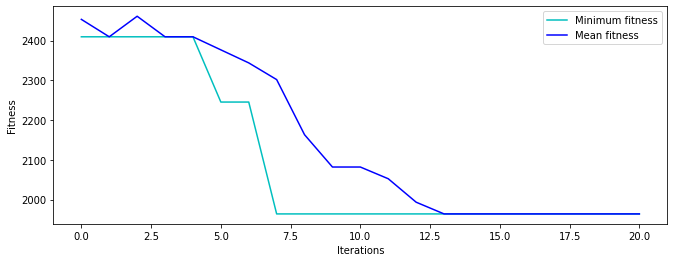

In [ ]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');

In [ ]:
best_individual = tools.selBest(result, k=1)[0]

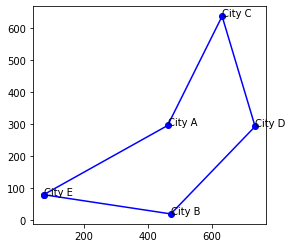

In [ ]:
plot_tour(create_tour((best_individual)))
plt.text(x=461,y=295,s="City A",fontsize=10);
plt.text(x=471,y=19,s="City B",fontsize=10);
plt.text(x=631,y=636,s="City C",fontsize=10);
plt.text(x=734,y=292,s="City D",fontsize=10);
plt.text(x=74,y=79,s="City E",fontsize=10);

In [ ]:
Cities(20)

{(113+299j),
 (186+154j),
 (188+387j),
 (196+516j),
 (232+478j),
 (232+637j),
 (265+416j),
 (278+111j),
 (296+663j),
 (392+583j),
 (437+639j),
 (487+571j),
 (489+368j),
 (63+416j),
 (636+537j),
 (639+225j),
 (759+169j),
 (930+639j),
 (935+131j),
 (995+493j)}

In [ ]:
cities=Cities(20)
toolbox.register("indices", numpy.random.permutation, len(cities))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
result,log=algorithms.eaSimple(toolbox.population(n=100), toolbox,
                                  cxpb=0.8, mutpb=0.1,
                                  ngen=1000, verbose=True,stats=fit_stats)

gen	nevals	mean   	min    
0  	100   	8567.07	6567.39
1  	87    	8076.09	6567.39
2  	83    	7788.42	6294.93
3  	86    	7475.64	6035.89
4  	73    	7172.16	6035.89
5  	91    	6977.45	5778.67
6  	85    	6823.16	5632.36
7  	87    	6538.69	5121.57
8  	88    	6293.31	5121.57
9  	89    	6209.82	4736.48
10 	90    	6139.29	4865.63
11 	82    	6039.8 	4657.78
12 	84    	5924.47	4657.78
13 	91    	5756.37	4620.83
14 	82    	5680.91	4543.37
15 	80    	5517.5 	4541.25
16 	78    	5483.44	4358.48
17 	77    	5300.56	4338.13
18 	81    	5287.82	4301.84
19 	81    	5229.83	4301.84
20 	81    	4999.74	4170.64
21 	82    	5024.99	4209.54
22 	76    	4929.09	3896.09
23 	80    	4773.1 	3781.4 
24 	84    	4720.62	3816.46
25 	84    	4652.72	3781.4 
26 	92    	4540.46	3781.4 
27 	80    	4377.29	3781.4 
28 	77    	4288.76	3710.38
29 	84    	4142.44	3696.96
30 	90    	4081.45	3696.96
31 	80    	4043.52	3696.96
32 	87    	3867.59	3653.81
33 	84    	4035.04	3615.84
34 	79    	3993.45	3478.49
35 	82    	4018.17	3478.49
3

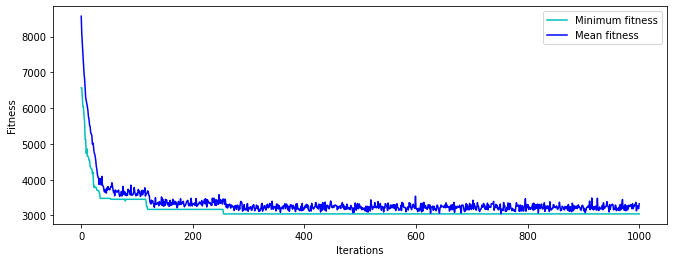

In [ ]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');

In [ ]:
best_individual = tools.selBest(result, k=1)[0]

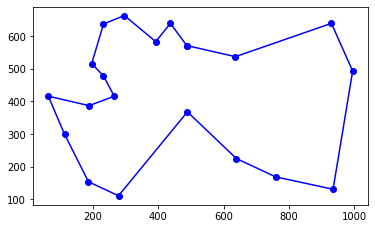

In [ ]:
plot_tour(create_tour(best_individual))

In [ ]:
create_tour(best_individual)

[(487+571j),
 (437+639j),
 (392+583j),
 (296+663j),
 (232+637j),
 (196+516j),
 (232+478j),
 (265+416j),
 (188+387j),
 (63+416j),
 (113+299j),
 (186+154j),
 (278+111j),
 (489+368j),
 (639+225j),
 (759+169j),
 (935+131j),
 (995+493j),
 (930+639j),
 (636+537j)]

In [ ]:
total_distance(create_tour(best_individual))

3043.8543537594815

In [ ]:
Cities_Listed=list(cities)

In [ ]:
Cities_Listed

[(232+478j),
 (188+387j),
 (636+537j),
 (186+154j),
 (392+583j),
 (63+416j),
 (232+637j),
 (278+111j),
 (296+663j),
 (759+169j),
 (113+299j),
 (489+368j),
 (196+516j),
 (487+571j),
 (930+639j),
 (639+225j),
 (265+416j),
 (995+493j),
 (935+131j),
 (437+639j)]

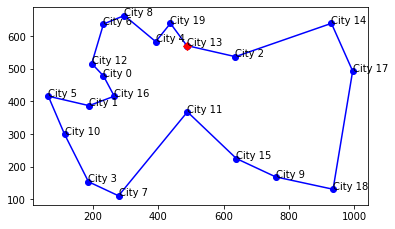

In [ ]:
for i in range(0,20):
  test="City {}".format(i)
  plt.text(x=X(Cities_Listed[i]),y=Y(Cities_Listed[i]),s=test,fontsize=10)
plot_tour(create_tour(best_individual))